In [1]:
import os
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from data_processor import series_to_supervised,evaluate
%matplotlib inline

In [2]:
names = locals()

In [3]:
dir_power = 'power_detrended'

name_index_power = pd.Series(os.listdir(dir_power)).map(lambda x:x[:-4])

for i in name_index_power:
    filename = 'power_detrended/'+str(i)+'.csv'
    names['data_%s' % i] = pd.read_csv(filename, index_col=3, parse_dates=True)
    names['power_%s' % i] = pd.DataFrame(names['data_%s' % i]['power_with_trend'])
    names['power_supervised_%s' % i] = series_to_supervised(names['power_%s' % i], 48, 16)

In [9]:
power_66 = pd.read_csv('66.csv', index_col=0, parse_dates=True)

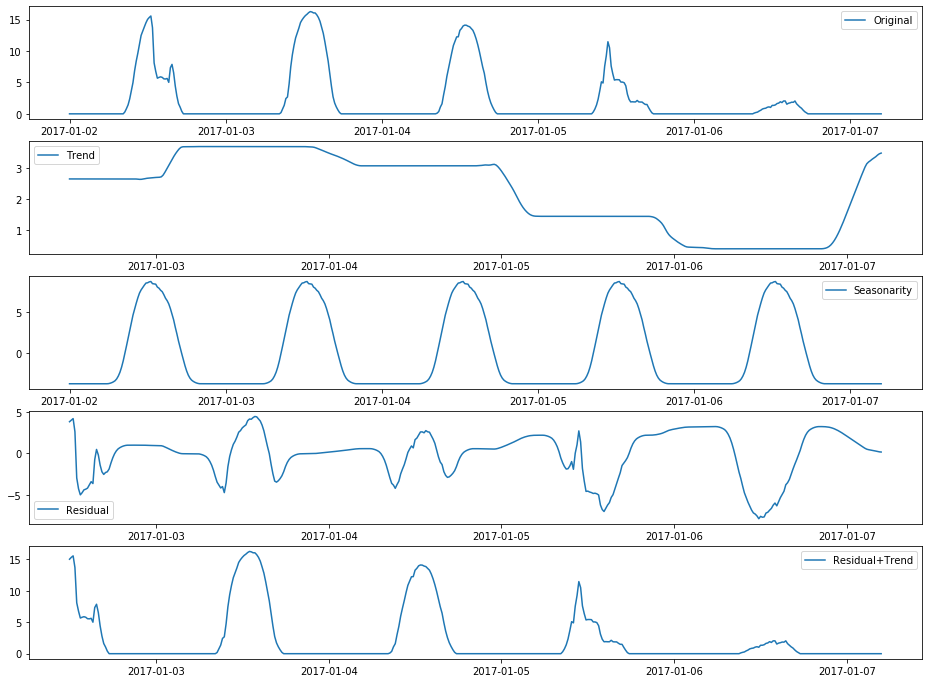

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

def decomposing(timeseries):
    decomposition = seasonal_decompose(timeseries, freq=96)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.figure(figsize=(16, 12))
    plt.subplot(511)
    plt.plot(timeseries[:500], label='Original')
    plt.legend(loc='best')
    plt.subplot(512)
    plt.plot(trend[:500], label='Trend')
    plt.legend(loc='best')
    plt.subplot(513)
    plt.plot(seasonal[:500], label='Seasonarity')
    plt.legend(loc='best')
    plt.subplot(514)
    plt.plot(residual[:500], label='Residual')
    plt.legend(loc='best')
    plt.subplot(515)
    plt.plot(residual[:500]+trend[:500]+seasonal[:500], label='Residual+Trend')
    plt.legend(loc='best')
    plt.show()


decomposing(power_66)

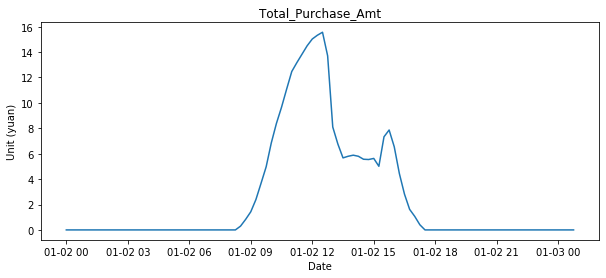

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

def purchase_seq_display(timeseries):
    graph = plt.figure(figsize=(10, 4))
    ax = graph.add_subplot(111)
    ax.set(title='Total_Purchase_Amt',
           ylabel='Unit (yuan)', xlabel='Date')
    plt.plot(timeseries)
    plt.show()

purchase_seq_display(power_66[:100])

In [21]:
decomposition = seasonal_decompose(power_66, freq=96)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

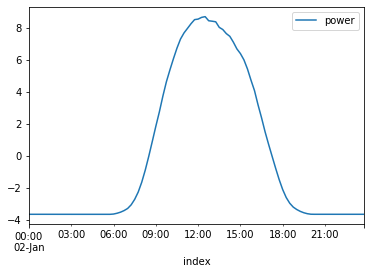

In [22]:
seasonal[:96].plot()

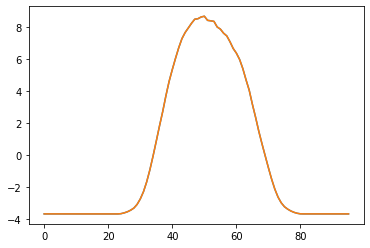

In [25]:
t = np.arange(96)
plt.plot(t, seasonal[:96], label='day1')
plt.plot(t, seasonal[96*100:96*101], label='day100')

In [38]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [39]:
# normalize features
index = power_66.index
scaler = MinMaxScaler(feature_range=(0,1))
power_66_normalized = pd.DataFrame(scaler.fit_transform(power_66))
power_66_normalized['index'] = index
power_66_normalized = power_66_normalized.set_index('index')

power_66_supervised = series_to_supervised(power_66_normalized, 48, 16)

index_of_input = list(range(16)) + list(range(-16,0,1))
# index_of_input =  list(range(-8,0,1))
inputs = power_66_supervised.iloc[:,:48]
inputs = inputs.iloc[:,index_of_input]
outputs = power_66_supervised.iloc[:,48:]

In [44]:
names = locals()
for i in range(16):
    names['output_%s' % str(i+1)] = outputs.iloc[:,i]

In [45]:
train_len = 1000
test_len = 48
for i in range(16):
    
    # split train and test(test one month)
    train_x,train_y = inputs[:train_len],names['output_%s'%str(i+1)][:train_len]
#     test_x,test_y = inputs[3000:3000+test_len],names['output_%s'%str(i+1)][3000:3000+test_len]

    clf = SVR(kernel='rbf',
              gamma = 'auto'
              )

    clf.fit(train_x, train_y)

    names['y_hat_%s' % str(i+1)] = clf.predict(inputs)

    #calculate rmse
    names['inv_yhat_%s' % str(i+1)] = scaler.inverse_transform(names['y_hat_%s' % str(i+1)].reshape(-1,1))

    names['test_output_%s'%str(i+1)] = pd.DataFrame(names['output_%s'%str(i+1)])
    names['inv_y_%s' % str(i+1)] = scaler.inverse_transform(names['test_output_%s'%str(i+1)])

#     names['rmse_%s' % str(i+1)] = evaluate(names['inv_y_%s' % str(i+1)],names['inv_yhat_%s' % str(i+1)])
    names['error_%s' % str(i+1)] = np.abs(names['inv_y_%s' % str(i+1)] - names['inv_yhat_%s' % str(i+1)])

In [46]:
error_svr = []
for i in range(16):
    error_svr.append(names['error_%s'%str(i+1)])

In [78]:
error = pd.DataFrame(np.array(error_svr).reshape(16,-1).T, index=inputs.index)

In [68]:
y = []
for i in range(16):
    y.append(names['inv_y_%s'%str(i+1)])
y = pd.DataFrame(np.array(y).reshape(16,-1).T, index=inputs.index).head()

In [69]:
y_hat = []
for i in range(16):
    y_hat.append(names['inv_yhat_%s'%str(i+1)])
y_hat = pd.DataFrame(np.array(y_hat).reshape(16,-1).T, index=inputs.index).head()

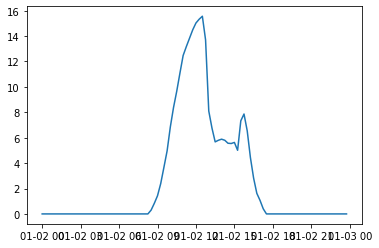

In [77]:
plt.plot(power_66[:96])

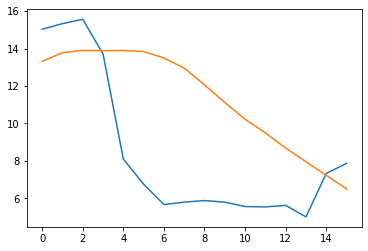

In [75]:
plt.plot(y.loc['2017-01-02 12:00:00'])
plt.plot(y_hat.loc['2017-01-02 12:00:00'])

In [66]:
inputs.index

DatetimeIndex(['2017-01-02 12:00:00', '2017-01-02 12:15:00',
               '2017-01-02 12:30:00', '2017-01-02 12:45:00',
               '2017-01-02 13:00:00', '2017-01-02 13:15:00',
               '2017-01-02 13:30:00', '2017-01-02 13:45:00',
               '2017-01-02 14:00:00', '2017-01-02 14:15:00',
               ...
               '2018-12-31 17:45:00', '2018-12-31 18:00:00',
               '2018-12-31 18:15:00', '2018-12-31 18:30:00',
               '2018-12-31 18:45:00', '2018-12-31 19:00:00',
               '2018-12-31 19:15:00', '2018-12-31 19:30:00',
               '2018-12-31 19:45:00', '2018-12-31 20:00:00'],
              dtype='datetime64[ns]', name='index', length=69921, freq=None)

In [ ]:
# 模型按点划分点随机性太大

In [79]:
error.mean()

0     1.691843
1     1.751909
2     1.886210
3     2.029264
4     2.167060
5     2.293820
6     2.413222
7     2.463942
8     2.422036
9     2.570122
10    2.850508
11    2.891532
12    2.976149
13    3.044604
14    3.114369
15    3.217769
dtype: float64

In [81]:
error[:1000].mean()

0     1.584192
1     1.606566
2     1.713131
3     1.819397
4     1.928570
5     1.991420
6     2.042422
7     2.061967
8     1.993536
9     1.964535
10    2.049949
11    2.071484
12    2.088328
13    2.098641
14    2.116449
15    2.120267
dtype: float64

In [82]:
error[1000:2000].mean()

0     1.571691
1     1.591452
2     1.694581
3     1.804634
4     1.894883
5     1.973648
6     2.052278
7     2.074420
8     2.003475
9     2.018914
10    2.220238
11    2.268753
12    2.337160
13    2.365546
14    2.396481
15    2.437906
dtype: float64

In [83]:
error[2000:3000].mean()

0     1.467133
1     1.453330
2     1.472187
3     1.497682
4     1.536027
5     1.561994
6     1.574456
7     1.574701
8     1.524132
9     1.476496
10    1.502695
11    1.522158
12    1.518828
13    1.538159
14    1.558336
15    1.547524
dtype: float64

In [84]:
error[3000:4000].mean()

0     1.609391
1     1.616382
2     1.673348
3     1.758529
4     1.849291
5     1.922105
6     1.996546
7     2.025847
8     1.963409
9     1.978769
10    2.158828
11    2.181091
12    2.232702
13    2.264064
14    2.303958
15    2.368695
dtype: float64

In [85]:
error[4000:5000].mean()

0     1.617987
1     1.637578
2     1.698255
3     1.783706
4     1.878631
5     1.939712
6     2.020762
7     2.072674
8     2.018928
9     2.018070
10    2.175515
11    2.209771
12    2.268528
13    2.310057
14    2.349314
15    2.417539
dtype: float64

### kmeans

In [104]:
import numpy as np
import matplotlib.pyplot as plt

# 先在四个中心点附近产生一堆数据
real_center = [(1, 1), (1, 2), (2, 2), (2, 1)]
point_number = 50

points_x = []
points_y = []

for center in real_center:
    offset_x, offset_y = np.random.randn(point_number) * 0.3, np.random.randn(point_number) * 0.25
    x_val, y_val = center[0] + offset_x, center[1] + offset_y

    points_x.append(x_val)
    points_y.append(y_val)
    
points_x = np.concatenate(points_x)
points_y = np.concatenate(points_y)

In [105]:
K         = 4
p_list    = np.stack([points_x, points_y], axis=1)
index     = np.random.choice(len(p_list), size=K)
centeroid = p_list[index]


In [106]:
centeroid

array([[1.2141416 , 0.99535586],
       [1.64444074, 0.7099593 ],
       [1.26211441, 2.15598924],
       [0.98072435, 0.88182324]])

In [107]:
points_set = {key: [] for key in range(K)}

for p in p_list:
    nearest_index = np.argmin(np.sum((centeroid - p) ** 2, axis=1) ** 0.5)
    points_set[nearest_index].append(p)

In [108]:
# points_set

In [109]:
for k_index, p_set in points_set.items():
    p_xs = [p[0] for p in p_set]
    p_ys = [p[1] for p in p_set]
    centeroid[k_index, 0] = sum(p_xs) / len(p_set)
    centeroid[k_index, 1] = sum(p_ys) / len(p_set)

In [110]:
for i in range(10):
    points_set = {key: [] for key in range(K)}

    for p in p_list:
        nearest_index = np.argmin(np.sum((centeroid - p) ** 2, axis=1) ** 0.5)
        points_set[nearest_index].append(p)
        
    for k_index, p_set in points_set.items():
        p_xs = [p[0] for p in p_set]
        p_ys = [p[1] for p in p_set]
        centeroid[k_index, 0] = sum(p_xs) / len(p_set)
        centeroid[k_index, 1] = sum(p_ys) / len(p_set)
print(centeroid)

[[1.44511502 0.97924646]
 [2.25884199 1.08205648]
 [1.45211519 2.02972252]
 [0.75359791 0.99753684]]


In [135]:

from sklearn import preprocessing
import pandas as pd
 
min_max_scaler = preprocessing.MinMaxScaler()
 
x = ([[3.],
              [2.],
              [0.],
              [1.]])#原数据
 
# y = [7., 1., -4., 987]#新的测试数据
# x.append(y)#将y添加到x的末尾
print('x ：\n', x)
x_minmax = min_max_scaler.fit_transform(x)


x ：
 [[3.0], [2.0], [0.0], [1.0]]


In [136]:
x_minmax

array([[1.        ],
       [0.66666667],
       [0.        ],
       [0.33333333]])

In [139]:
y = ([[3., -1.],
              [2., 0.],
              [0., 1.],
              [1., 2.]])#原数据

In [132]:
y_minmax = min_max_scaler.fit_transform(y)

In [134]:
min_max_scaler.inverse_transform(x_minmax)

ValueError: operands could not be broadcast together with shapes (4,2) (4,) (4,2) 

In [137]:
min_max_scaler.inverse_transform(y_minmax)

array([[3.   , 0.   , 3.   , 3.   ],
       [2.   , 1.   , 1.8  , 0.714],
       [0.   , 2.   , 1.2  , 0.   ],
       [1.   , 3.   , 0.   , 2.256]])

In [141]:
for i,j in y:
    print(i,j)

3.0 -1.0
2.0 0.0
0.0 1.0
1.0 2.0
